In [25]:
from typing import Any, Sequence

import torch
import torch.utils.data as data
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE

from chainconsumer import ChainConsumer

from jaxili.model import ConditionalMAF
from jaxili.utils import create_data_loader
from jaxili.train import TrainerModule

In [3]:
num_dim = 3
prior = utils.BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape)

In [4]:
thetas = prior.sample((5000,))
xs = simulator(thetas)

In [9]:
inference = SNPE(prior)

density_estimator = inference.append_simulations(thetas, xs).train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 101 epochs.

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

[]

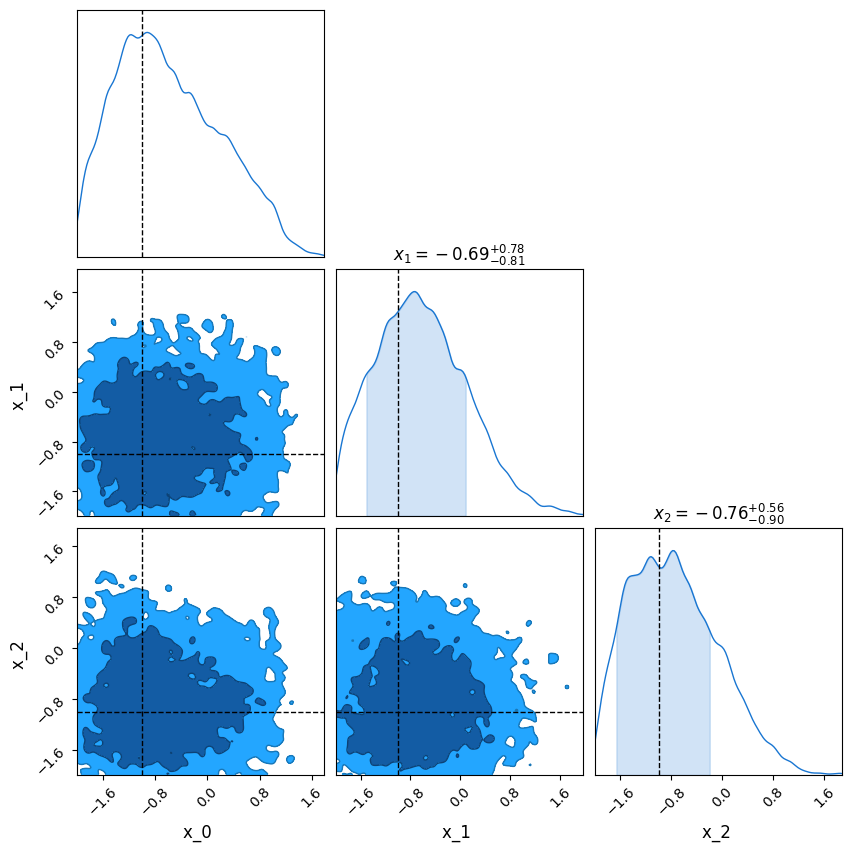

In [12]:
x_o = torch.zeros(3,)

posterior_samples = posterior.sample((5000,), x=x_o)

c = ChainConsumer()
c.add_chain(posterior_samples.numpy(), parameters=["x_{}".format(i) for i in range(num_dim)])
fig = c.plotter.plot(figsize=2., truth=[-1.0, -1.0, -1.0])
plt.plot()

In [19]:
#using jaxili
def create_dataset(num_data):
    thetas = prior.sample((num_data,))
    xs = simulator(thetas)
    return thetas.numpy(), xs.numpy()

In [18]:
class JaxiliDataset(data.Dataset):
    def __init__(self, thetas, xs):
        self.thetas = thetas
        self.xs = xs

    def __len__(self):
        return len(self.thetas)

    def __getitem__(self, idx):
        return self.thetas[idx], self.xs[idx]

In [21]:
train_set = JaxiliDataset(thetas, xs)
val_set = JaxiliDataset(*create_dataset(1000))
test_set = JaxiliDataset(*create_dataset(2000))

batch_size = 50
train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train=[True, False, False],
    batch_size=batch_size
)

In [26]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_in : int,
                 n_cond : int,
                 n_layers : int,
                 layers : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 activation : str = 'silu',
                 trial : Any = None,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_in,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'layers': layers,
                             'use_reverse': use_reverse,
                             'seed': seed,
                             'activation': activation
                         },
                         
                         **kwargs)
        self.trial = trial
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
        
    def print_tabulate(self, exmp_input):
        pass


In [29]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_in=num_dim,
    n_cond=num_dim,
    n_layers=5,
    layers=[50, 50],
    use_reverse=True,
    seed=42,
    activation='relu',
    optimizer_hparams={
        'lr': 5e-4,
        'optimizer_name': 'adam'
    },
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    trial=None
)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


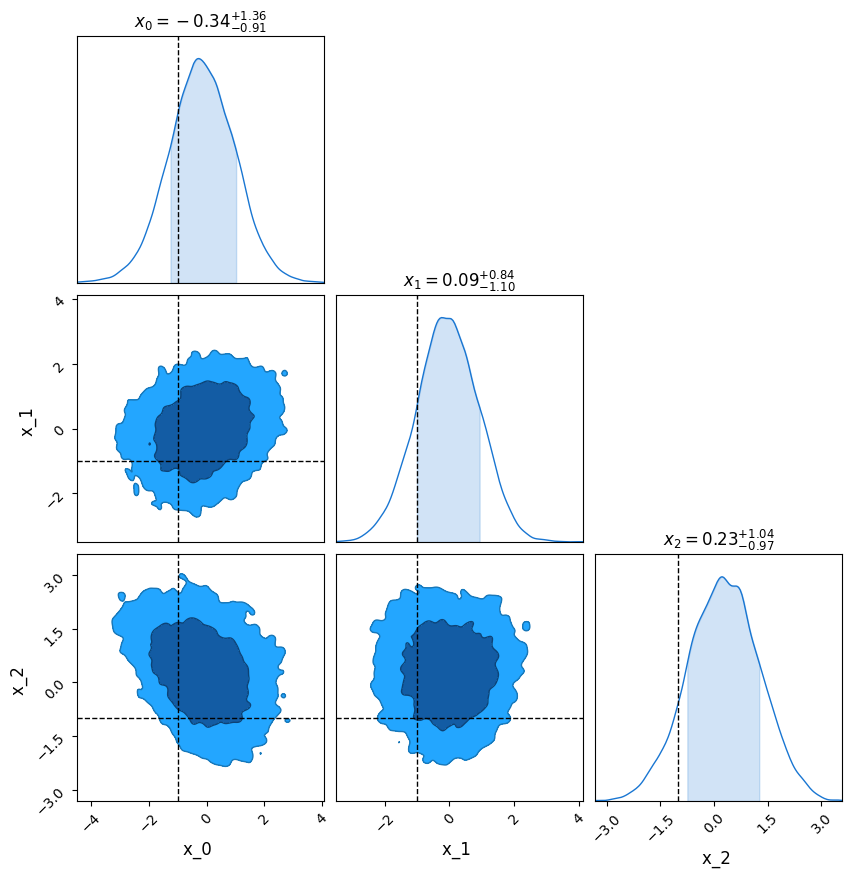

In [34]:
key = jax.random.PRNGKey(42)
pre_samples = trainer.model.apply(
    {'params': trainer.state.params}, x_o.numpy().reshape((-1, 3)), num_samples=10000, key=key, method='sample'
)

c = ChainConsumer()
c.add_chain(pre_samples, parameters=["x_{}".format(i) for i in range(num_dim)])
fig = c.plotter.plot(figsize=2., truth=[-1.0, -1.0, -1.0])
plt.show()

In [35]:
trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=150
)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 1
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_1.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/100 [00:00<?, ?it/s]

/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/local/home/sg276684/anaconda3/envs/jaxili/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
INFO:absl:Saving checkpoint at step: 2
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_2.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/chec

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 3
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_3.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_3.orbax-checkpoint-tmp-1709635805005421 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_3
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_3`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 4
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_4.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_4.orbax-checkpoint-tmp-1709635805337568 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_4
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_4`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_3


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 5
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_5.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_5.orbax-checkpoint-tmp-1709635805645304 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_5
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_5`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_4


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 6
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_6.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_6.orbax-checkpoint-tmp-1709635805937056 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_6
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_6`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_5


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 9
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_9.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_9.orbax-checkpoint-tmp-1709635806839900 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_9
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_9`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_6


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 11
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_11.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_11.orbax-checkpoint-tmp-1709635807431371 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_11
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_11`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_9


Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 12
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_12.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_12.orbax-checkpoint-tmp-1709635807724183 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_12
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_12`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_11


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 14
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_14.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_14.orbax-checkpoint-tmp-1709635808327422 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_14
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_14`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_12


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 16
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_16.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_16.orbax-checkpoint-tmp-1709635808949920 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_16
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_16`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_14


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 18
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_18.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_18.orbax-checkpoint-tmp-1709635809515464 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_18
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_18`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_16


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Saving checkpoint at step: 30
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/training_techniques/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30.
INFO:absl:Renaming /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30.orbax-checkpoint-tmp-1709635813044455 to /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30
INFO:absl:Finished saving checkpoint to `/local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30`.
INFO:absl:Removing checkpoint at /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_18


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:absl:Restoring orbax checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30
INFO:absl:Restoring item from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30.
INFO:absl:Finished restoring checkpoint from /local/home/sg276684/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/version_40/checkpoint_30.


Neural network training stopped after 51 epochs.
Early stopping with best validation metric: 3.1716256141662598
Best model saved at epoch 30
Early stopping parameters: min_delta=0.001, patience=20


{'val/loss': 3.1716256141662598,
 'train/loss': 3.07655668258667,
 'epoch_time': 0.11993789672851562,
 'test/loss': 3.5421619415283203}

In [36]:
model = trainer.bind_model()

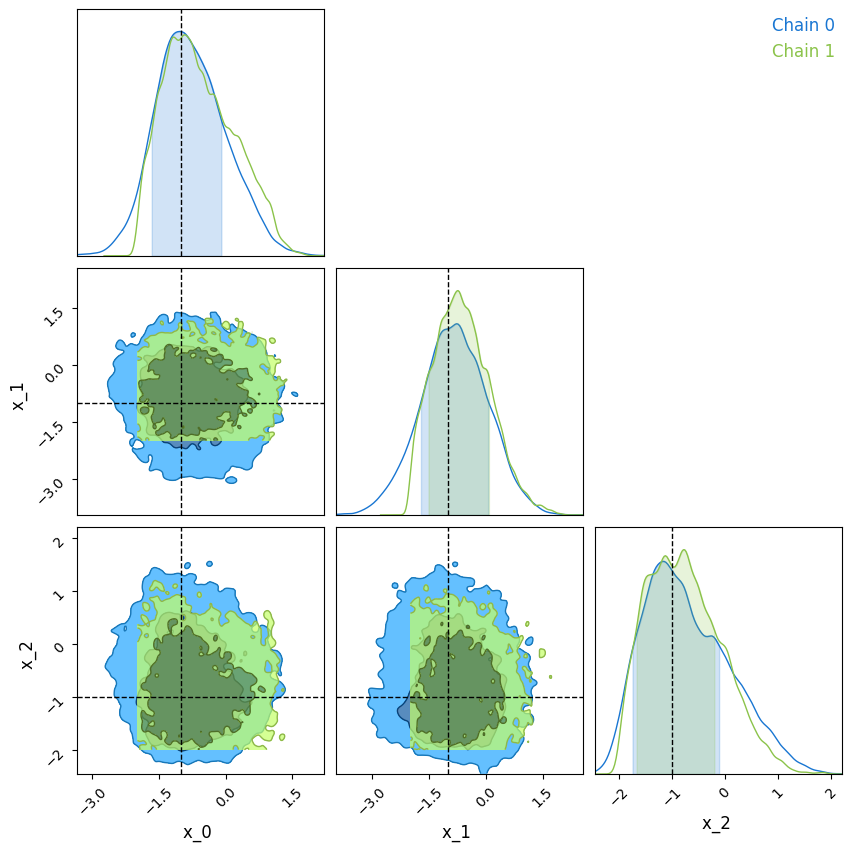

In [38]:
samples_jaxili = model.sample(x_o.numpy().reshape((-1, 3)), num_samples=10000, key=key)

c = ChainConsumer()
c.add_chain(samples_jaxili, parameters=["x_{}".format(i) for i in range(num_dim)])
c.add_chain(posterior_samples.numpy(), parameters=["x_{}".format(i) for i in range(num_dim)])
fig = c.plotter.plot(figsize=2., truth=[-1.0, -1.0, -1.0])
plt.show()


In [45]:
log_probability = model.log_prob(samples_jaxili, x_o.numpy().reshape((-1, 3))*jnp.ones((10000, 1)))
print(jnp.mean(log_probability))

-3.5589354


In [44]:
log_probability = posterior.log_prob(posterior_samples, x=x_o)
print(torch.mean(log_probability))

tensor(-3.1594)
